To install the required python packages, you can uncomment the lines below. Versions of matplotlib older than 3.4 may not support arrays of alphas for scatter plots, which will break generating figure 2E. Otherwise it should work fine.

In [1]:
#!pip install pandas
#!pip install "matplotlib>=3.4"
#!pip install numpy

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import wilcoxon, mannwhitneyu, ranksums
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as hcluster
from scipy.spatial.distance import squareform

This notebook, gives a small demo of analyzing the results of the compass algorithm and replicates figures 2E and 2C from the paper.

The file "extdata/Th17/reactions.tsv" is the outputs of a compass run and "extdata/Th17/cell_metadata.csv" is cell metadata, in this case it is only used to know the condition of the Th17 cells (pathogenic vs. non-pathogenic)

In [2]:
reactions = pd.read_csv("extdata/Th17/reactions.tsv", sep="\t", index_col = 0)

In [3]:
cell_metadata = pd.read_csv("extdata/Th17/cell_metadata.csv", index_col = 0)

In [4]:
# pathogenic Th17 = Th17p; non-pathogenic Th17 = Th17n

Th17p_cells = cell_metadata.index[cell_metadata['cell_type'] == 'Th17p']
Th17n_cells = cell_metadata.index[cell_metadata['cell_type'] == 'Th17n']

The reaction metadata for RECON2 is stored here. We'll be using the confidence scores and the subsystem groupings to filter out reactions and group them for analysis.

In [5]:
reaction_metadata = pd.read_csv("extdata/RECON2/reaction_metadata.csv", index_col = 0) 

Here is one example of a row for the reaction metadata:

In [6]:
reaction_metadata.loc[['r0281']]

,reaction_name,formula,associated_genes,subsystem,EC_number,confidence
reaction_no_direction,,,,,,
r0281,Putrescine:oxygen oxidoreductase (deaminating)...,1.00 * Water [e] + 1.00 * O2 [e] + 1.00 * Putr...,AOC1,Methionine and cysteine metabolism,1.4.3.6,0.0


In [7]:
def cohens_d(x, y):
    pooled_std = np.sqrt(((len(x)-1) * np.var(x, ddof=1) 
                          + (len(y)-1) * np.var(y, ddof=1)) / 
                             (len(x) + len(y) - 2))
    return (np.mean(x) - np.mean(y)) / pooled_std
    

def wilcoxon_test(consistencies_matrix, group_A_cells, group_B_cells):
    """
        Performs an unpaired wilcoxon test (or mann-whitney U test) for each reaction between group_A and group_B
    """
    #per reaction/meta-reaction, conduct wilcoxon test between group_A and group_B
    group_A = consistencies_matrix.loc[:,group_A_cells]
    group_B = consistencies_matrix.loc[:,group_B_cells]
    results = pd.DataFrame(index = consistencies_matrix.index, columns = ['wilcox_stat', 'wilcox_pval', 'cohens_d'], dtype='float64')
    for rxn in consistencies_matrix.index:
        A, B = group_A.loc[rxn].to_numpy().ravel(), group_B.loc[rxn].to_numpy().ravel()
        stat, pval = mannwhitneyu(A, B, alternative='two-sided')
        c_d = cohens_d(A, B)
        results.loc[rxn, ['wilcox_stat', 'wilcox_pval', 'cohens_d']] = stat, pval, c_d
    results['adjusted_pval'] = np.array(multipletests(results['wilcox_pval'], method='fdr_bh')[1], dtype='float64')
    return results

In [8]:
def get_reaction_consistencies(compass_reaction_scores, min_range=1e-3):
    df = -np.log(compass_reaction_scores + 1)
    df = df[df.max(axis=1) - df.min(axis=1) >= min_range]
    df = df - df.min().min()
    return df

The numbers in the reactions tsv correspond to penalties for each reaction per cell, so we take the negative log to get scores that are higher the more active the reaction is predicted to be.This also drops reactions that are close to constant and therefore not informative for the comparison.

In [9]:
reaction_consistencies = get_reaction_consistencies(reactions)

We use the unpaired Wilcoxon rank-sum test (equivlanet to the Mann–Whitney U test) to analyze which reactions are predicted to be more active in pathogenic Th17p cells compared to the non-pathogenic Th17n cells. Positive values indicate higher potential activity in Th17p. 

In [10]:
wilcox_results = wilcoxon_test(reaction_consistencies, Th17p_cells, Th17n_cells)
wilcox_results['metadata_r_id'] = ""
for r in wilcox_results.index:
    if r in reaction_metadata.index:
        wilcox_results.loc[r, 'metadata_r_id'] = r
    elif r[:-4] in reaction_metadata.index:
        wilcox_results.loc[r, 'metadata_r_id'] = r[:-4]
    else:
        print("Should not occur")

Next we join the metadata to the reactions in a new dataframe W, so that we can filter out non-core reactions. More specifically, we remove reactions with confidence other than 0 or 4 (4 = most confident; 0 = unassigned confidence) and filter out reactions in the citric acid cycle subsystem which are outside of the mitochondria.

In [11]:
W = wilcox_results.merge(reaction_metadata, how='left', 
                         left_on='metadata_r_id', right_index=True, validate='m:1')
W = W[W['confidence'].isin([0,4])]
W = W[~W['EC_number'].isna()]
W.loc[(W['formula'].map(lambda x: '[m]' not in x)) & (W['subsystem'] == "Citric acid cycle"), 'subsystem'] = 'Other'

Here is one example of a row of the reuslting dataframe for a reaction:

In [12]:
wilcox_results.loc[['r0281_pos']]

,wilcox_stat,wilcox_pval,cohens_d,adjusted_pval,metadata_r_id
r0281_pos,9269.0,0.085969,-0.221507,0.153082,r0281


The "_neg" or "_pos" suffixes indicate one direction of a bidirectional reaction. The "_pos" direction indicates positive flux through the reaction. For this example reaction it indicates water, oxygen, and putrescine are being consumed by this reaction to produce ammonium, hyrodgen peroxide, and 4-Aminobutanal.

In [13]:
reaction_metadata.loc['r0281']['formula']

'1.00 * Water [e] + 1.00 * O2 [e] + 1.00 * Putrescine [e] --> 1.00 * Ammonium [e] + 1.00 * Hydrogen peroxide [e] + 1.00 * 4-Aminobutanal [e]\nAOC1'

# Optional: Metareaction analysis
[Metareactions](#Metareactions) are used in the paper rather than single reaction analysis and the section at the bottom of this notebook performs the same analysis using reactions clustered into metareactions.

# Figure 2C replication

In [14]:
labeled_reactions = {
    "PGM_neg" : "phosphoglycerate mutase (PGAM)",
    "LDH_L_neg" : "lactate dehydrogenase",
    "PDHm_pos" : "pyruvate dehydrogenase (PDH)",
    "TPI_neg" : "triosephosphate isomerase (DHAP forming)",
    "FACOAL1821_neg" : "long-chain fatty-acid-CoA ligase",
    "r1257_pos" : "long-chain fatty-acid-CoA ligase",
    "FACOAL1831_neg" : "long-chain fatty-acid-CoA ligase",
    "CSNATr_neg" : "carnitine O-acetyltransferase",
    "C160CPT1_pos" : "carnitine O-palmitoyltransferase",
    "ACONTm_pos" : "aconitate hydratase",
    "SUCOASm_pos" : "succinate-CoA ligase",
    "AKGDm_pos" : "alpha-ketoglutarate dehydrogenase",
    "SUCD1m_pos" : "succinate dehydrogenase",
    "ICDHyrm_pos" : "isocitrate dehydrogenase",
    "CK_pos" : "creatine\nkinase",
    "PGCD_pos" : "phosphoglycerate dehydrogenase",
    "ARGSS_pos" : "arginosuccinate synthase",
    "r0281_neg" : "putrescine diamine oxidase",
    "SPMDOX_pos" : "spermidine dehydrogenase (spermidine -> GABA)",
    "ARGDCm_pos" : "arginine decarboxylase",
    "AGMTm_pos" : "agmatinase",
    "GHMT2r_pos" : "serine hydroxymethyltransferase",
    "AHC_pos" : "adenosylhomocysteinase",
    "METAT_pos" : "methionine adenosyltransferase",
    "METS_pos" : "methionine\nsynthase",
    "ARGN_pos" : "arginase"
}

In [15]:
def plot_differential_scores(data, title, c):
    plt.figure(figsize=(10,10))
    axs = plt.gca()
    axs.scatter(data['cohens_d'], -np.log10(data['adjusted_pval']), c=c)
    axs.set_xlabel("Cohen's d", fontsize=16)
    axs.set_ylabel("-log10 (Wilcoxon-adjusted p)", fontsize=16)
    #Everything after this should be tweaked depending on your application
    axs.set_xlim(-2.2, 2.2)
    axs.axvline(0, dashes=(3,3), c='black')
    axs.axhline(1, dashes=(3,3), c='black')
    axs.set_title(title, fontdict={'fontsize':20})
    axs.annotate('', xy=(0.5, -0.08), xycoords='axes fraction', xytext=(0, -0.08), 
            arrowprops=dict(arrowstyle="<-", color='#348C73', linewidth=4))
    axs.annotate('Th17p', xy=(0.75, -0.12), xycoords='axes fraction', fontsize=16)
    axs.annotate('', xy=(0.5, -0.08), xycoords='axes fraction', xytext=(1, -0.08), 
            arrowprops=dict(arrowstyle="<-", color='#E92E87', linewidth=4))
    axs.annotate('Th17n', xy=(0.25, -0.12), xycoords='axes fraction', fontsize=16)
    for r in data.index:
        if r in labeled_reactions:
            x = data.loc[r, 'cohens_d']
            y = -np.log10(data.loc[r, 'adjusted_pval'])
            offset = (20, 0)
            if x < 0:
                offset = (-100, -40)
            axs.annotate(labeled_reactions[r], (x,y), xytext = offset, 
                         textcoords='offset pixels', arrowprops={'arrowstyle':"-"})

In [16]:
amino_acid_metab = ["Alanine and aspartate metabolism",
            "Arginine and Proline Metabolism",
            "beta-Alanine metabolism",
            "Cysteine Metabolism",
            "D-alanine metabolism",
            "Folate metabolism",
            "Glutamate metabolism",
            "Glycine, serine, alanine and threonine metabolism",
            "Histidine metabolism",
            "Lysine metabolism",
            "Methionine and cysteine metabolism",
            "Taurine and hypotaurine metabolism",
            "Tryptophan metabolism",
            "Tyrosine metabolism",
            "Urea cycle",
            "Valine, leucine, and isoleucine metabolism"]

In [17]:
filtered_data = pd.concat([W[W['subsystem'] == "Glycolysis/gluconeogenesis"],
             W[W['subsystem'] == "Citric acid cycle"],
            W[W['subsystem'].isin(amino_acid_metab)],
           W[W['subsystem'] == "Fatty acid oxidation"]])

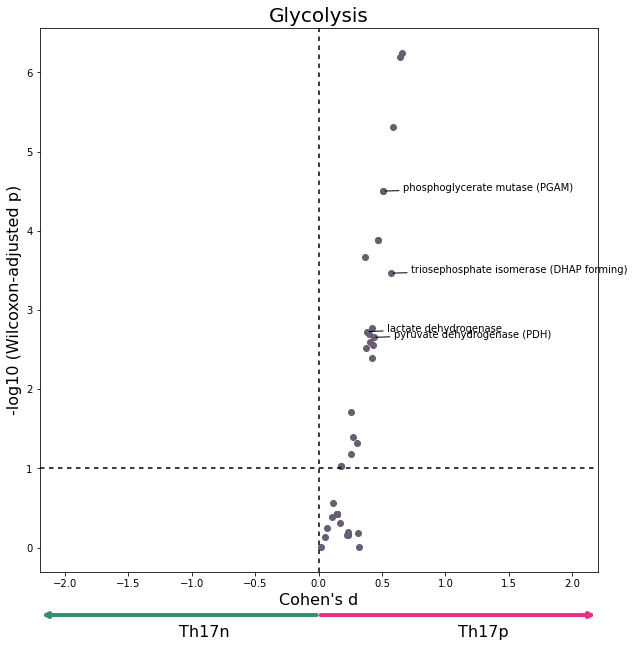

In [18]:
data = W[W['subsystem'] == "Glycolysis/gluconeogenesis"]
plot_differential_scores(data, title='Glycolysis', c="#695D73")

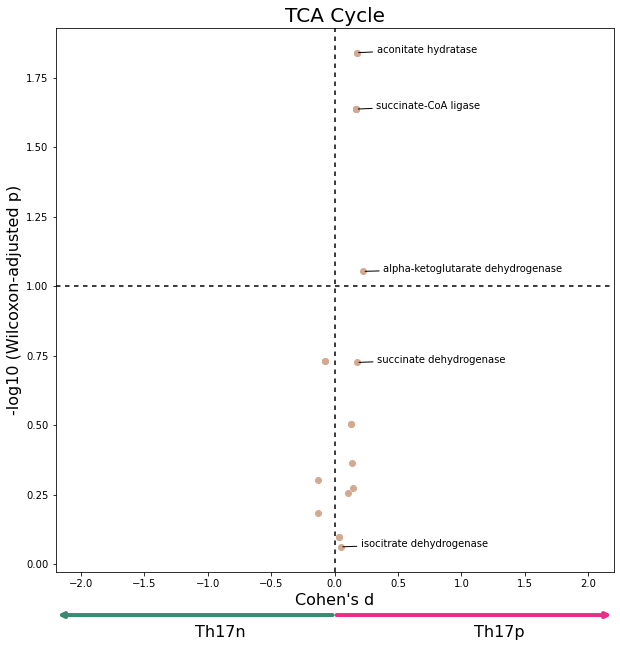

In [19]:
data = W[W['subsystem'] == "Citric acid cycle"]
plot_differential_scores(data, title="TCA Cycle", c="#D3A991")

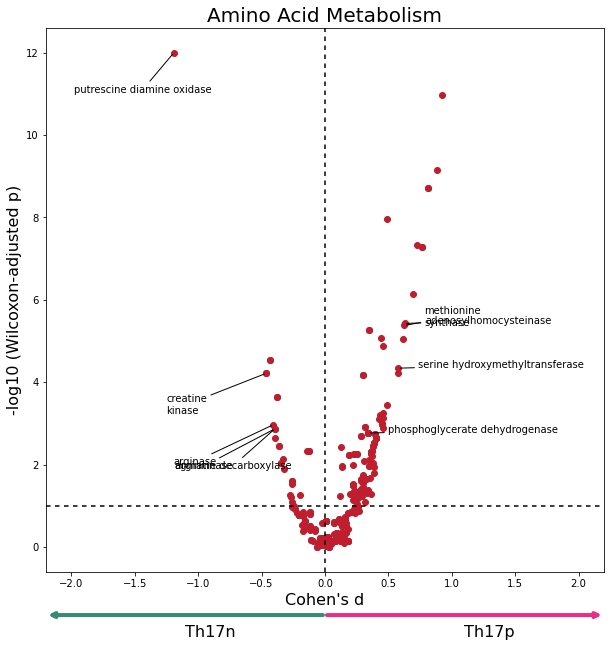

In [20]:
data = W[W['subsystem'].isin(amino_acid_metab)].copy()
data['adjusted_pval'] = data['adjusted_pval'].clip(1e-12)
plot_differential_scores(data, "Amino Acid Metabolism", c="#BF1E2E")

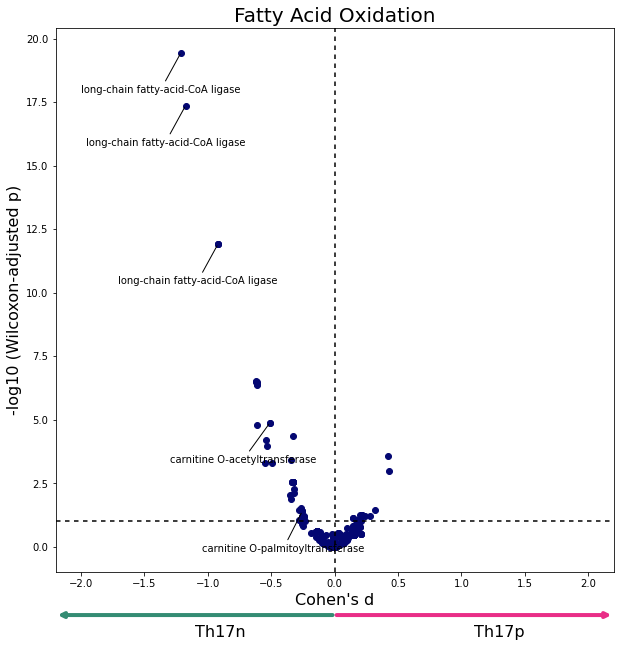

In [21]:
data = W[W['subsystem'] == "Fatty acid oxidation"]
plot_differential_scores(data, "Fatty Acid Oxidation", c="#040772")

# Figure 2E replication

In [22]:
data = W[~W['subsystem'].isin(["Miscellaneous", "Unassigned"])]
data = data[~data['subsystem'].map(lambda x: "Transport" in x or "Exchange" in x or x == "Other")]
items, counts = np.unique(data['subsystem'], return_counts=True)
items = [items[i] for i in range(len(items)) if counts[i] > 5] #filter(n() > 5) %>%
data = data[data['subsystem'].isin(items)]

Text(0.5, 0, "Cohen's d")

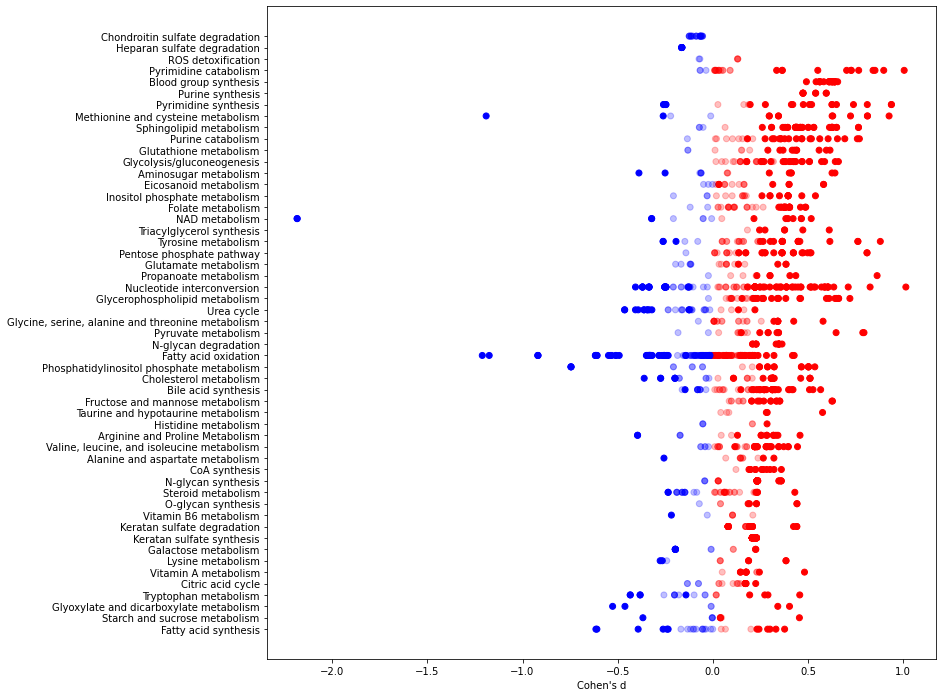

In [23]:
plt.figure(figsize=(12,12))
axs = plt.gca()
#Sorts the reactions for plotting
d = data[data['adjusted_pval'] < 0.1].groupby('subsystem')['cohens_d'].median().abs()
axs.scatter(d[d.argsort], d[d.argsort].index, alpha=0)
color = data['cohens_d'].map(lambda x: 'r' if x >= 0 else 'b')
alpha = data['adjusted_pval'].map(lambda x: 1.0 if x < 0.1 else 0.25)
axs.scatter(data['cohens_d'], data['subsystem'], c=color, alpha=alpha)
axs.set_xlabel("Cohen's d")

# Metareactions
The following section analyzes the the results by clustering the reactions into metareactions, as done in the manuscript. It will be repeating the previous analysis for the clustered reactions instead of single reactions.

In [24]:
reactions = pd.read_csv("extdata/Th17/reactions.tsv", sep="\t", index_col = 0)
reactions[reactions <= 1e-4] = 0
reactions = reactions[np.all(reactions != 0, axis=1)]

In [25]:
reactions = reactions[reactions.max(axis=1) - reactions.min(axis=1) != 0]

We group reactions into metareactions using heirarchical clustering as detailed in the manuscript.

In [26]:
def get_metareactions(reactions, height=0.02):
    """
        Returns an array of metareaction labels for each reaction
        Index k in the returned array has the metareaction label for reaction k.
    """
    #pairwise_reaction_correlations = reactions.T.corr(method='spearman') #Pandas method here is orders of magnitude slower
    pairwise_reaction_correlations = np.corrcoef(reactions.rank(axis=1))
    #Unfortunately due to floating point issues, these matrices are not always perfectly symmetric and the diagonal may be slightly off from 1
    pairwise_reaction_correlations[np.arange(reactions.shape[0]), np.arange(reactions.shape[0])] = 1.0
    pairwise_reaction_correlations = (pairwise_reaction_correlations + pairwise_reaction_correlations.T)/2
    assert(np.all(pairwise_reaction_correlations == pairwise_reaction_correlations.T))

    Z = hcluster.complete(squareform(1 - pairwise_reaction_correlations))
    return hcluster.fcluster(Z, height, criterion='distance')

In [27]:
meta_rxns_map = get_metareactions(reactions)
meta_rxns = reactions.join(pd.DataFrame(meta_rxns_map, columns=["meta_rxn_id"], index = reactions.index)).groupby("meta_rxn_id").mean()

In [28]:
meta_rxn_consistencies = get_reaction_consistencies(meta_rxns)

In [29]:
wilcox_meta_rxn_results = wilcoxon_test(meta_rxn_consistencies, Th17p_cells, Th17n_cells)

Now each row of the dataframe contains the results of the statistical tests for each metareaction:

In [30]:
wilcox_meta_rxn_results.iloc[0:1]

,wilcox_stat,wilcox_pval,cohens_d,adjusted_pval
meta_rxn_id,,,,
1,4172.0,7.900994e-19,-1.261458,1.360551e-16


Next the metareaction results dataframe is expanded out to each reaction that makes up the metareactions so that the metadata can be joined to it and used to generate plots.

In [31]:
wilcox_meta_rxn_expanded = pd.DataFrame(index=reactions.index, columns=wilcox_meta_rxn_results.columns)
for i in range(len(wilcox_meta_rxn_expanded.index)):
    if (meta_rxns_map[i] in wilcox_meta_rxn_results.index):
        wilcox_meta_rxn_expanded.loc[wilcox_meta_rxn_expanded.index[i]] = wilcox_meta_rxn_results.loc[meta_rxns_map[i]]
wilcox_meta_rxn_expanded = wilcox_meta_rxn_expanded.dropna().astype('float64')

In [32]:
wilcox_meta_rxn_expanded['metadata_r_id'] = ""
for r in wilcox_meta_rxn_expanded.index:
    if r in reaction_metadata.index:
        wilcox_meta_rxn_expanded.loc[r, 'metadata_r_id'] = r
    elif r[:-4] in reaction_metadata.index:
        wilcox_meta_rxn_expanded.loc[r, 'metadata_r_id'] = r[:-4]
    else:
        print("Should not occur")

Now each row contains information on a single reaction:

In [33]:
wilcox_meta_rxn_expanded.iloc[0:1]

,wilcox_stat,wilcox_pval,cohens_d,adjusted_pval,metadata_r_id
10FTHF5GLUtl_pos,12939.0,0.000613,0.390921,0.002207,10FTHF5GLUtl


To generate the following figures with the metareactions, simply uncomment the cell below and run it. Then you can generate the figures with the previous cells for [Figure 2C replication](#Figure-2C-replication) and [Figure 2E replication](#Figure-2E-replication) using the metareaction based data.

In [ ]:
#W = wilcox_meta_rxn_expanded.merge(reaction_metadata, how='left', 
#                         left_on='metadata_r_id', right_index=True, validate='m:1')
#W = W[W['confidence'].isin([0,4])]
#W = W[~W['EC_number'].isna()]
#W.loc[(W['formula'].map(lambda x: '[m]' not in x)) & (W['subsystem'] == "Citric acid cycle"), 'subsystem'] = 'Other'